In [1]:
from ensembles import VanillaEnsemble, BootstrapEnsemble
from datasets import make_dataset, make_cross_validation_dataset
from plot import plot_dataset, plot_prediction
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 4]
from evaluation import evaluate_model
import tensorflow as tf

# Explanation



Showing the efficiency of two types of ensembles, Vanilla Network Ensemble with different initialisation parameters and Bootstrap Ensemble grown by presenting copies of the exact same model with different subsets of the dataset.

All underlying Estimators are built in tensorflow (1.4) and are based on the same parent object (ToDo: Make this more beautiful and readable). Can be found in /estimators. The Ensembles simulate Online Training rather than actually training online at the moment (ToDo: Rewrite Ensembles to train online properly). The Code can be found in /ensembles.

VanillaEnsemble, which is an ensemble of the class EnsembleNetwork that differ in two significant ways: 
    1. different number of layers 
    2. different initial conditions (translates to different seeds at weight initialisation time)
    3. each of the networks are shown the full dataset
Inspired by an approach used in [1]

    
   
BootstrapEnsemble, which is an ensemble of the class EnsembleNetwork in which each part of the ensemble:
    1. share the exact same hyperparameters
    2. share the same initial conditions (translates to setting the same seed at weight initialisation time)
    3. are each shown  ~ 50% of the Dataset
Expansion of [2] to (kind of) work with Deep Networks 


No Regularisation has been added, thus quite a bit of overfitting occurs.

ToDo:

- add Dropout Ensemble from [3]





# Parameters
parameters have been chosen at 'random', i.e. not much thought has been put into them. No Gridsearch for optimal parameter spaces or similar.

each neural network is contains three hidden layers with 10 neurons each, the learning rate has been set to 0.001 which seems a literature standard (cite needed)

The layers are instantiated by draws from a normal distribution (0,1), for the Bootstrap network a distribution over parameters can be achieved by assuming that each $w_i$ is a draw from a normal distribution. While thinkable in theory, the same is non-trivial for an ensemble with differing hyperparameters (i.e. different number of layers and different layer sizes).

# Dataset 
The Dataset contains 100 samples generated by the function 

$5 \cdot sin(X) + 10 + X^2 + noise$

where X is linearly spaced patches in the intervall [-5,5] the noise is drawn from a normal distribution (0,4)

# Training
Each network is trained on 10 * 100 = 1000 epochs

Training is offline. The datasets are shown to the estimators as a whole (although it should be relatively easy to switch to online) (ToDo: Switch to Online). The Bootstrap in the Bootstrap Estimator is achieved by randomly drawing  sub-datasets that each contain ~ 50% of datapoints.
The optimizer is the standard implementation of tensorflow's tf.train.GradientDescentOptimizer 


# Evaluation
Right now, the RSME and the coverage probability of the prediction is reported, where the data is available (i.e. VanillaNetwork does not return uncertainty = no Coverage). At the moment, evaluation happens on the training set (because the data generating model is a bit annoying to work with because of quite frankly a bit of a stupid shuffling situation, which is on the ToDo list) (ToDo: solve that)

# Problems/ToDo

It's not entirely clear (ToDo: Literature search) what scaling factor should be used for the variance. While the VanillaEnsemble can to a certain extend be influenced by choosing vastly different models (including untouched hyperparameters such as but not limited to _weight initialisation schemes, optimisation algorithms, learning rate,..._, it's not entirely obvious which hyperparameters apart from the number of estimators $p_{keep}$ that regulates the size of the subsampled datasets can be chosen to generate inherently greater (or lower) variance in the samples.

Hyperparameters need to be tuned

No real Online Training

Evaluation on training set (alas only to make a point about uncertainty so maybe can be forgiven in this phase)




[1] Lakshminarayanan, B., Pritzel, A., & Blundell, C. (2017). Simple and scalable predictive uncertainty estimation using deep ensembles. In Advances in Neural Information Processing Systems (pp. 6405-6416).
Chicago	

Link: https://arxiv.org/abs/1612.01474



[2] Eckles, D., & Kaptein, M. (2014). Thompson sampling with the online bootstrap. arXiv preprint arXiv:1410.4009.

Link: https://arxiv.org/abs/1410.4009


[3] Gal, Y., & Ghahramani, Z. (2016, June). Dropout as a Bayesian approximation: Representing model uncertainty in deep learning. In international conference on machine learning (pp. 1050-1059).

Link: http://proceedings.mlr.press/v48/gal16.html

# Preparations

In [2]:

from global_vars import SEED as seed
#seed = 
data = make_dataset(train_p=0.8,seed=seed)

X = data['X']
y = data['y']
X_test = data['X_test']
y_test = data['y_test']
generate_sinoid = data['generating']
#sorted_index = data['train_index']
sorted_index = data['shuffle_index']
#test_index = data['test_ind']

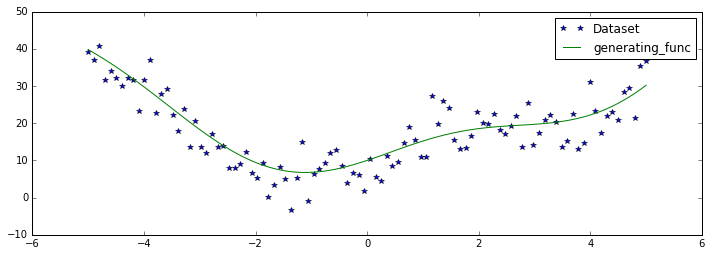

In [3]:
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Initialise Ensembles

In [4]:
num_epochs = 10
num_eps = 75#25#100
#ensemble = [{'num_neurons':[10,10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
#            {'num_neurons':[10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
#            {'num_neurons':[10,10,10,10,10,10],'num_epochs':num_epochs}]#,'optimizer':tf.train.AdamOptimizer}]
        

ensemble = [{'num_neurons':[10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,5,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,5,20],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,5],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10],'num_epochs':num_epochs}]#,'optimizer':tf.train.AdamOptimizer}]
        
    
    
vanilla = VanillaEnsemble(estimator_stats = ensemble)


#bootstrap_ensemble = {'num_neurons':[10,10,10,10,10],'num_epochs':num_epochs}#,'optimizer':tf.train.AdamOptimizer}
bootstrap_ensemble = {'num_neurons':[10,10,10],'num_epochs':num_epochs}#,'optimizer':tf.train.AdamOptimizer}

bootstrap = BootstrapEnsemble(estimator_stats= bootstrap_ensemble)

In [5]:
def get_mean_var(pred_dict):
    return pred_dict['means'],pred_dict['stds']
    

Vanilla Ensemble already displays a measure of uncertainty due to the ensembled models being initialised differently.
Bootstrap Ensemble does not have uncertainty die to the fact that all contained models are initialised in exactly the same way (thus each sample returns the exact same values)

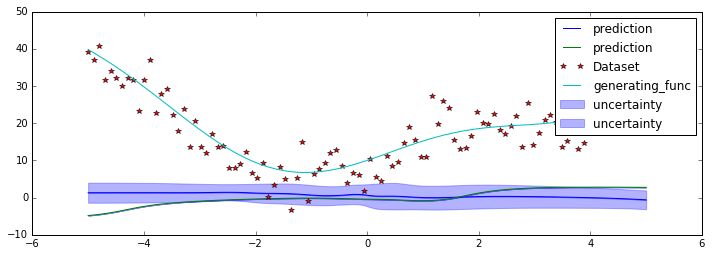

In [6]:
vanilla_pred_dict = vanilla.predict(X)
vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
bootstrap_pred_dict = bootstrap.predict(X)
bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_dict)
plot_prediction(X,
                vanilla_preds,
                sorted_index,
                vanilla_var)

plot_prediction(X,
                bootstrap_preds,
                sorted_index,
                bootstrap_var)

plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Training

## Vanilla Ensemble

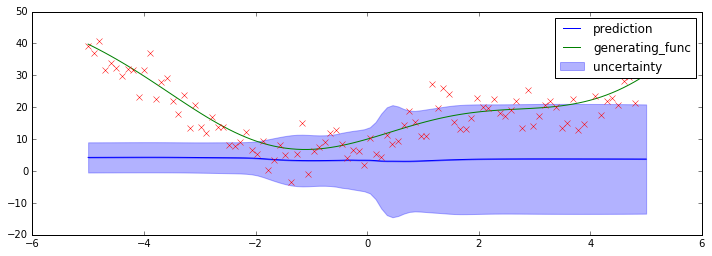

RSME is 16.76142692565918
COVERAGE PROBABILITY is 0.53
MEAN VARIANCE is 11.37086296081543
COVERAGE/MEAN_VAR is 0.0466103585828452
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.087703474, 0.38556853708131622)


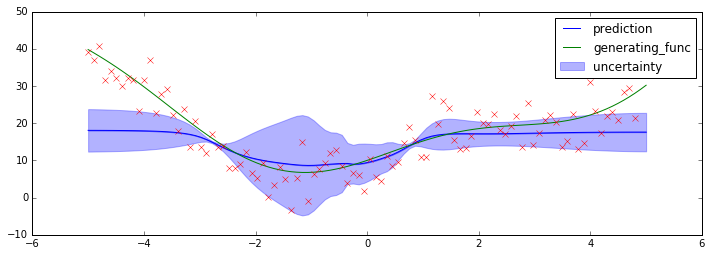

RSME is 7.787463188171387
COVERAGE PROBABILITY is 0.46
MEAN VARIANCE is 4.971220970153809
COVERAGE/MEAN_VAR is 0.09253259968964278
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.11745672, 0.24449145270815772)


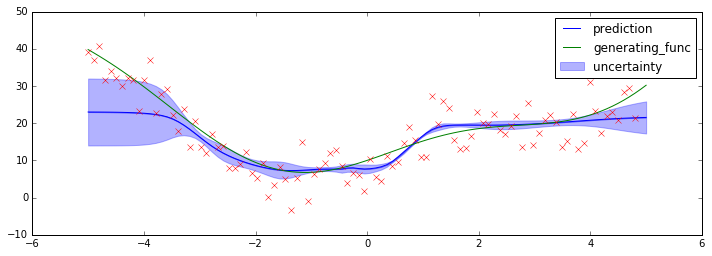

RSME is 5.98720121383667
COVERAGE PROBABILITY is 0.22
MEAN VARIANCE is 2.4269542694091797
COVERAGE/MEAN_VAR is 0.09064859720391726
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.59267509, 8.2424221920110941e-11)


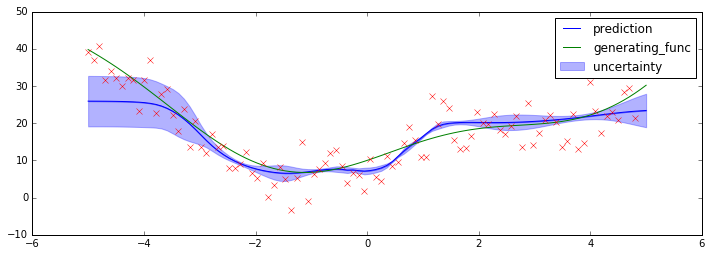

RSME is 5.271668910980225
COVERAGE PROBABILITY is 0.31
MEAN VARIANCE is 2.2097041606903076
COVERAGE/MEAN_VAR is 0.14029027302150554
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.40479219, 2.9501023214701328e-05)


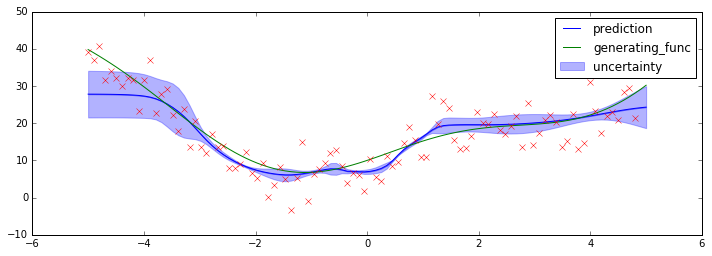

RSME is 4.888438701629639
COVERAGE PROBABILITY is 0.35
MEAN VARIANCE is 2.3496506214141846
COVERAGE/MEAN_VAR is 0.14895831610460683
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34442103, 0.00044994735968392665)


In [7]:
vanilla_error_list = []
for i in range(num_eps):
    vanilla.train(X,y)
    #errors = vanilla.train_and_evaluate(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #vanilla_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        vanilla_pred_dict = vanilla.predict(X)
        vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
        vanilla_var = vanilla_var**2
        plot_prediction(X,vanilla_preds,sorted_index,vanilla_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,vanilla_preds,var=vanilla_var)

In [8]:
#plt.plot(np.squeeze(vanilla_error_list))

## Bootstrap Ensemble

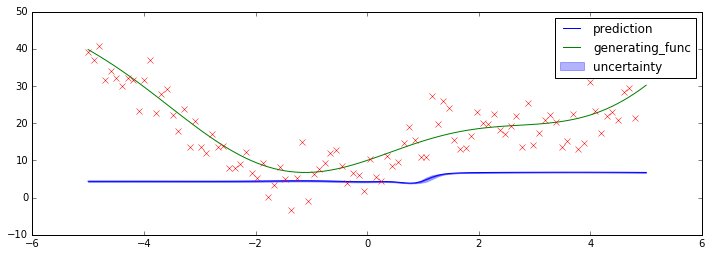

RSME is 15.514591217041016
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 0.13169336318969727
COVERAGE/MEAN_VAR is 0.0
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.013204897, 0.89625435314123547)


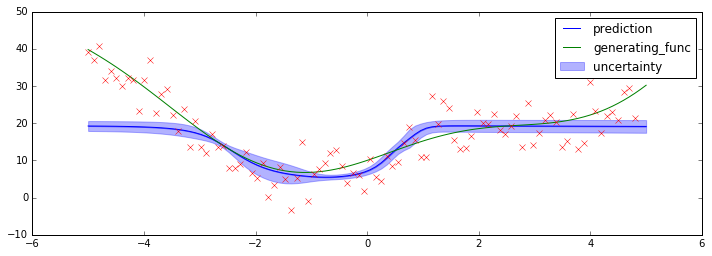

RSME is 7.171961307525635
COVERAGE PROBABILITY is 0.2
MEAN VARIANCE is 1.5750333070755005
COVERAGE/MEAN_VAR is 0.12698144166319705
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.077430844, 0.44384049576747009)


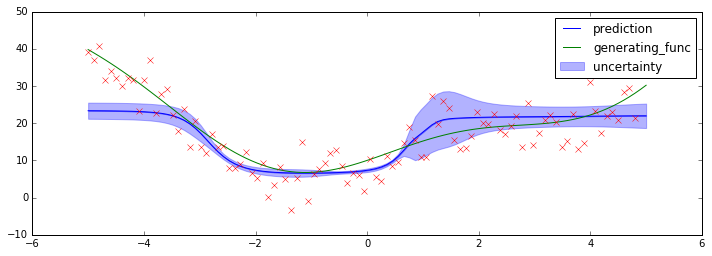

RSME is 5.986399173736572
COVERAGE PROBABILITY is 0.29
MEAN VARIANCE is 2.4767889976501465
COVERAGE/MEAN_VAR is 0.11708708342742861
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.087086186, 0.388934442937658)


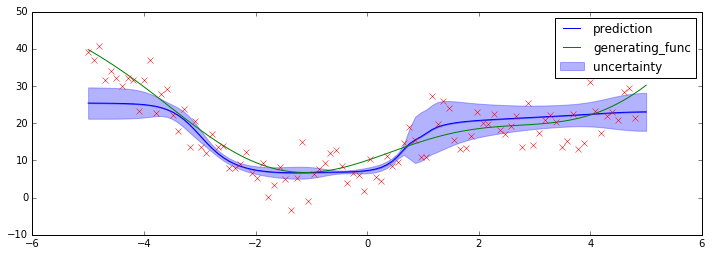

RSME is 5.48549222946167
COVERAGE PROBABILITY is 0.33
MEAN VARIANCE is 2.88041353225708
COVERAGE/MEAN_VAR is 0.11456688295080095
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.30580497, 0.0019742375443459904)


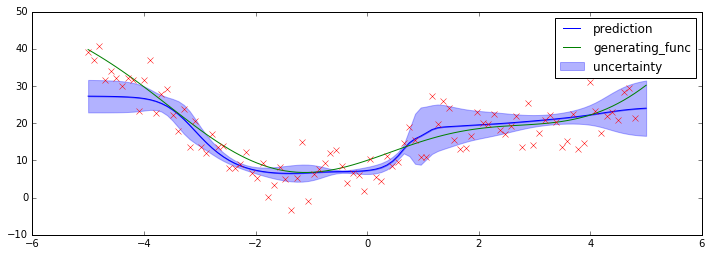

RSME is 5.0374274253845215
COVERAGE PROBABILITY is 0.38
MEAN VARIANCE is 2.8924736976623535
COVERAGE/MEAN_VAR is 0.13137543836858717
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34614149, 0.00041934074310041793)


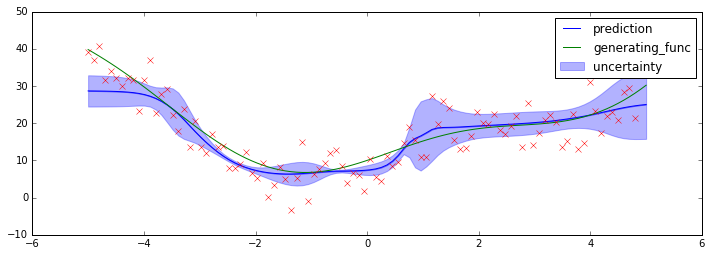

RSME is 4.770401954650879
COVERAGE PROBABILITY is 0.44
MEAN VARIANCE is 3.439063787460327
COVERAGE/MEAN_VAR is 0.12794179671931305
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.32889444, 0.00083461179338800478)


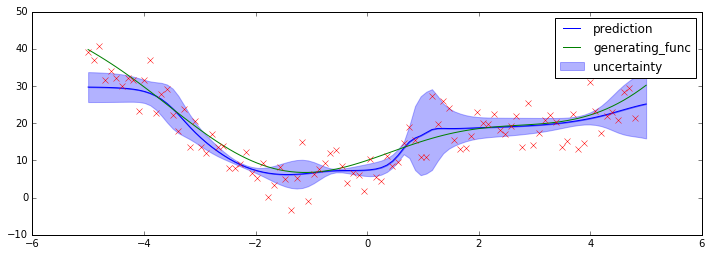

RSME is 4.603695869445801
COVERAGE PROBABILITY is 0.43
MEAN VARIANCE is 3.2095518112182617
COVERAGE/MEAN_VAR is 0.1339750922533895
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.35953113, 0.00023901819692390792)


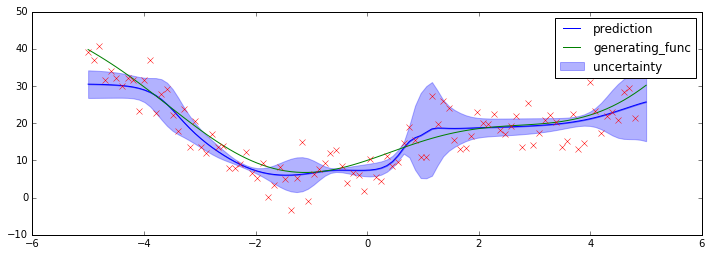

RSME is 4.491309642791748
COVERAGE PROBABILITY is 0.47
MEAN VARIANCE is 3.457873582839966
COVERAGE/MEAN_VAR is 0.13592168387312384
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.36583936, 0.00018181995006346743)


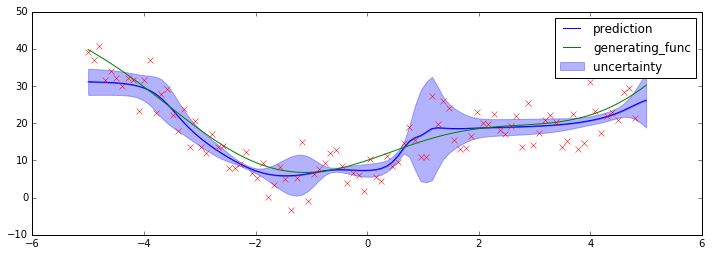

RSME is 4.406518459320068
COVERAGE PROBABILITY is 0.42
MEAN VARIANCE is 3.0813872814178467
COVERAGE/MEAN_VAR is 0.13630224364616197
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.35272071, 0.00031911813112791312)


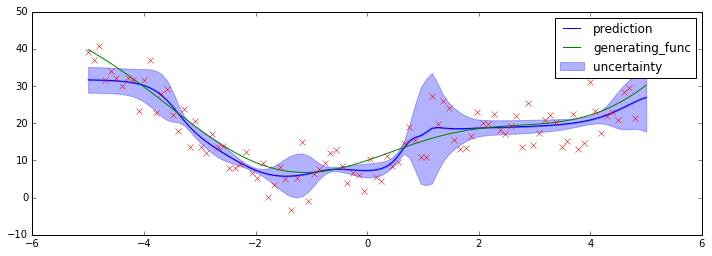

RSME is 4.328338146209717
COVERAGE PROBABILITY is 0.45
MEAN VARIANCE is 3.320641279220581
COVERAGE/MEAN_VAR is 0.13551599289448807
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.36957008, 0.00015425166391518517)


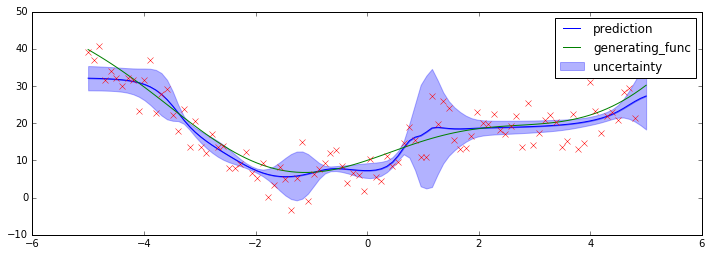

RSME is 4.285094261169434
COVERAGE PROBABILITY is 0.43
MEAN VARIANCE is 3.2021830081939697
COVERAGE/MEAN_VAR is 0.1342833932038506
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.37984526, 9.7054187900555896e-05)


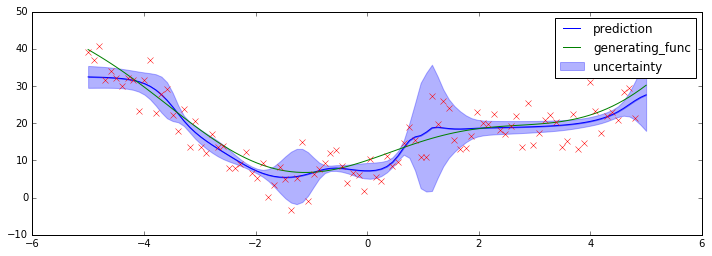

RSME is 4.244973182678223
COVERAGE PROBABILITY is 0.44
MEAN VARIANCE is 3.2068254947662354
COVERAGE/MEAN_VAR is 0.1372073412532459
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.38550234, 7.4704311647677372e-05)


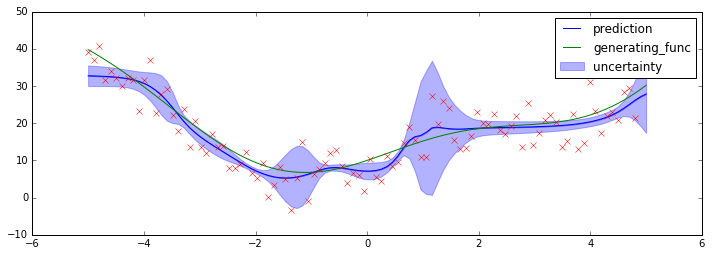

RSME is 4.214468479156494
COVERAGE PROBABILITY is 0.44
MEAN VARIANCE is 3.352276563644409
COVERAGE/MEAN_VAR is 0.13125408707975347
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39267838, 5.3228505899793356e-05)


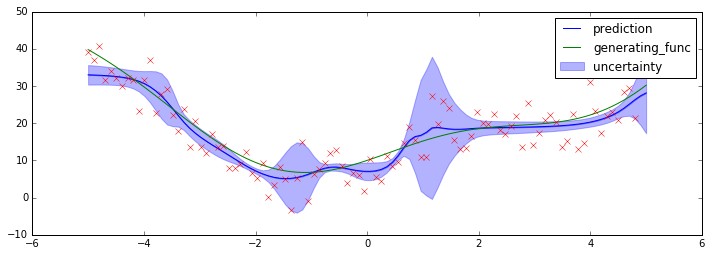

RSME is 4.187108993530273
COVERAGE PROBABILITY is 0.45
MEAN VARIANCE is 3.5322883129119873
COVERAGE/MEAN_VAR is 0.1273961693203418
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39247274, 5.3753887996417865e-05)


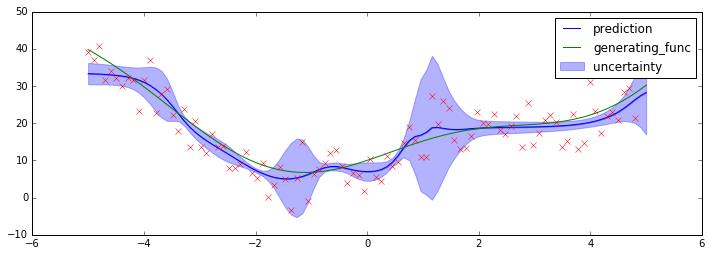

RSME is 4.1804656982421875
COVERAGE PROBABILITY is 0.5
MEAN VARIANCE is 3.723834753036499
COVERAGE/MEAN_VAR is 0.1342701900486558
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39791259, 4.1363371116197259e-05)


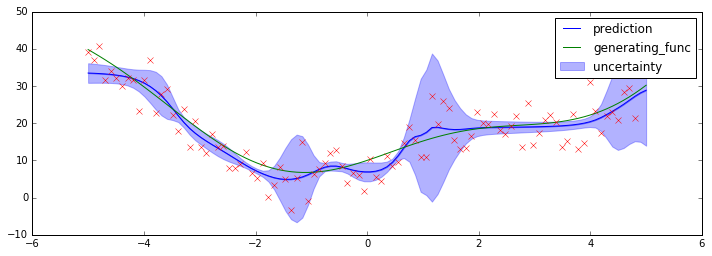

RSME is 4.131284236907959
COVERAGE PROBABILITY is 0.51
MEAN VARIANCE is 4.255847930908203
COVERAGE/MEAN_VAR is 0.11983510883838497
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.37002614, 0.00015116123745046326)


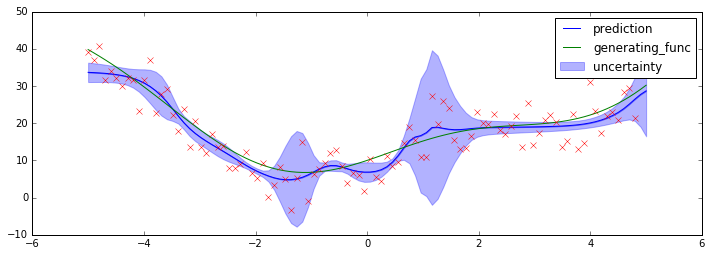

RSME is 4.132933139801025
COVERAGE PROBABILITY is 0.49
MEAN VARIANCE is 3.869922399520874
COVERAGE/MEAN_VAR is 0.12661752598984044
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.40026435, 3.6881032084388804e-05)


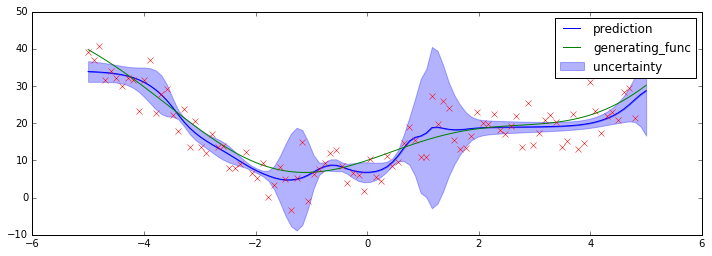

RSME is 4.128927230834961
COVERAGE PROBABILITY is 0.5
MEAN VARIANCE is 3.983200788497925
COVERAGE/MEAN_VAR is 0.125527189451213
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39522633, 4.7103892182456121e-05)


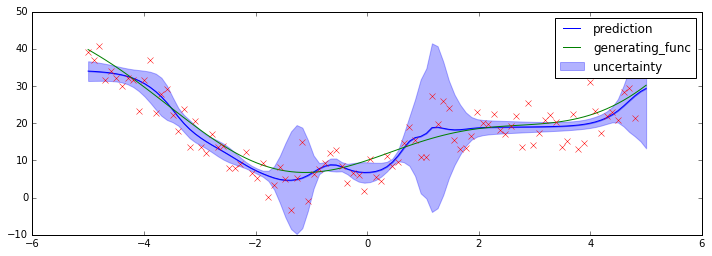

RSME is 4.082545757293701
COVERAGE PROBABILITY is 0.51
MEAN VARIANCE is 4.264154434204102
COVERAGE/MEAN_VAR is 0.11960167200069778
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.40837097, 2.4671598151721498e-05)


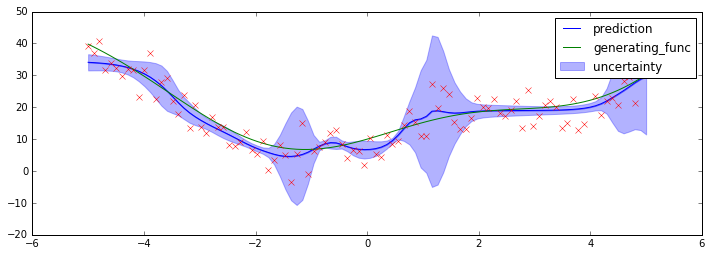

RSME is 4.064752101898193
COVERAGE PROBABILITY is 0.53
MEAN VARIANCE is 4.833990573883057
COVERAGE/MEAN_VAR is 0.10964026344268617
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.37447017, 0.00012391064428673111)


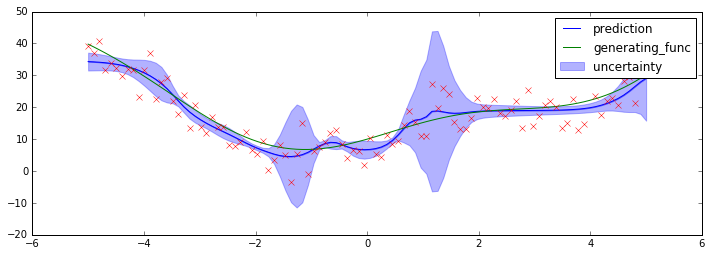

RSME is 4.089523792266846
COVERAGE PROBABILITY is 0.51
MEAN VARIANCE is 4.385677337646484
COVERAGE/MEAN_VAR is 0.11628762463261484
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39774033, 4.1710923728261022e-05)


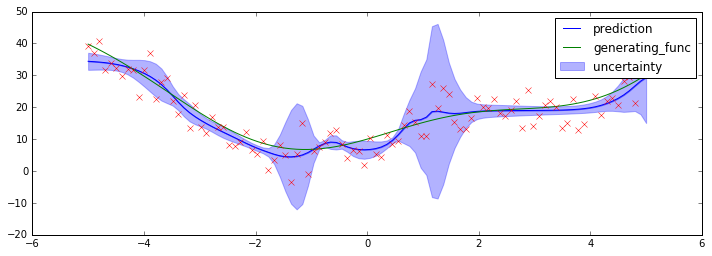

RSME is 4.07103157043457
COVERAGE PROBABILITY is 0.5
MEAN VARIANCE is 4.523388862609863
COVERAGE/MEAN_VAR is 0.11053659439562634
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39915991, 3.8926297536423837e-05)


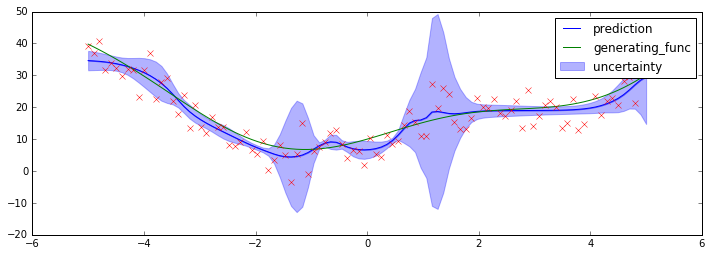

RSME is 4.065439701080322
COVERAGE PROBABILITY is 0.52
MEAN VARIANCE is 4.724883079528809
COVERAGE/MEAN_VAR is 0.1100556333876218
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39607978, 4.5204082840254563e-05)


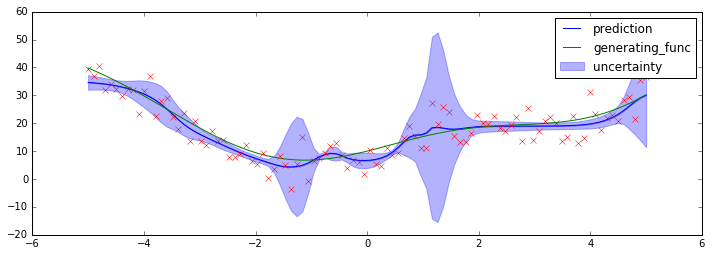

RSME is 4.034086227416992
COVERAGE PROBABILITY is 0.51
MEAN VARIANCE is 5.091939926147461
COVERAGE/MEAN_VAR is 0.10015829082764999
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.40680099, 2.6691101837913217e-05)


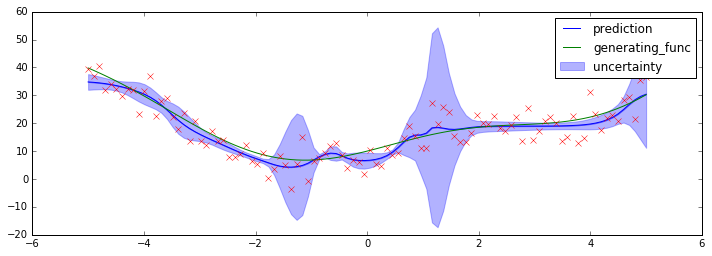

RSME is 4.020226001739502
COVERAGE PROBABILITY is 0.51
MEAN VARIANCE is 5.084770202636719
COVERAGE/MEAN_VAR is 0.10029951790850615
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39963394, 3.803580453777677e-05)


In [9]:
gauss_error_list = []
for i in range(num_eps*5):
    bootstrap.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = bootstrap.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2
        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

# Old Stuff, can probably be deleted, kept for security reasons

In [10]:
vanilla.train(X,y)
bootstrap.train(X,y)

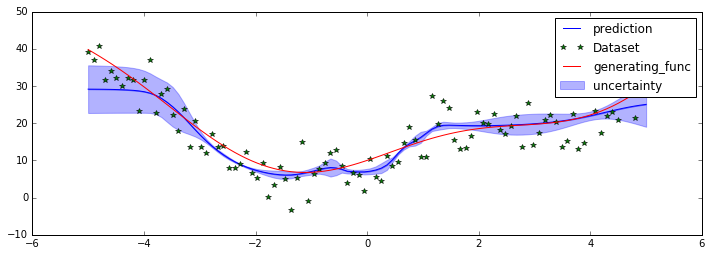

In [11]:
vanilla_pred_dict = vanilla.predict(X)
vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
bootstrap_pred_dict = bootstrap.predict(X)
bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_dict)
plot_prediction(X,
                vanilla_preds,
                sorted_index,
                vanilla_var**2)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

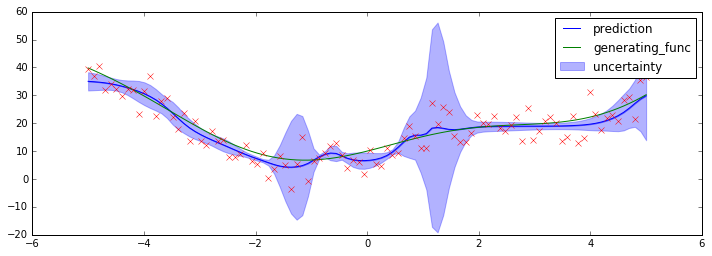

RSME is 4.039511203765869
COVERAGE PROBABILITY is 0.53
MEAN VARIANCE is 5.1423659324646
COVERAGE/MEAN_VAR is 0.1030653996546654
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3969661, 4.3306995147351583e-05)


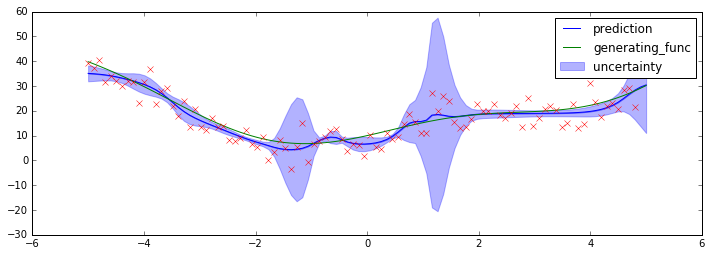

RSME is 4.008768081665039
COVERAGE PROBABILITY is 0.49
MEAN VARIANCE is 5.203329563140869
COVERAGE/MEAN_VAR is 0.09417047182078217
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.40758684, 2.5661643865857729e-05)


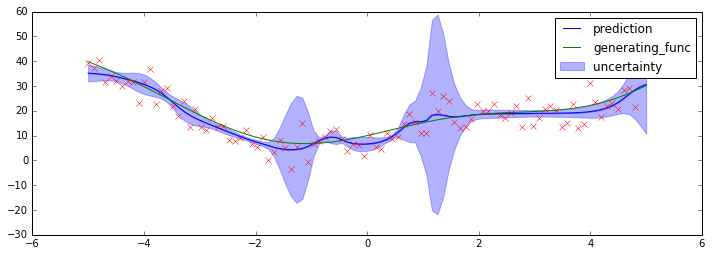

RSME is 4.001041412353516
COVERAGE PROBABILITY is 0.51
MEAN VARIANCE is 5.369229316711426
COVERAGE/MEAN_VAR is 0.09498569904858664
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.40671015, 2.68125585938829e-05)


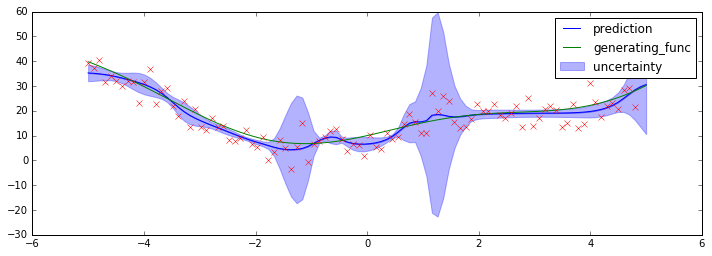

RSME is 3.9945662021636963
COVERAGE PROBABILITY is 0.5
MEAN VARIANCE is 5.390510082244873
COVERAGE/MEAN_VAR is 0.09275560055937702
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.40915996, 2.3711610533979737e-05)


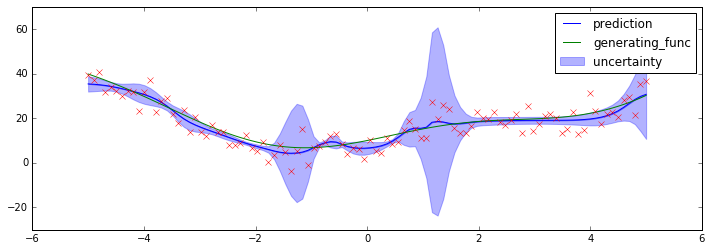

RSME is 3.9883694648742676
COVERAGE PROBABILITY is 0.51
MEAN VARIANCE is 5.5107102394104
COVERAGE/MEAN_VAR is 0.09254705434386362
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.40687567, 2.6591628729516407e-05)


In [12]:
#gauss_error_list = []
for i in range(num_eps):
    bootstrap.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = bootstrap.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [13]:
evaluate_model(X,y,vanilla_preds,var=vanilla_var**2)

RSME is 4.656434535980225
COVERAGE PROBABILITY is 0.34
MEAN VARIANCE is 2.2307257652282715
COVERAGE/MEAN_VAR is 0.15241676287591882
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.29880941, 0.002529102237984626)


In [14]:
evaluate_model(X,y,bootstrap_preds,var=bootstrap_var**2)

RSME is 3.9883694648742676
COVERAGE PROBABILITY is 0.76
MEAN VARIANCE is 92.15758514404297
COVERAGE/MEAN_VAR is 0.00824674386608671
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3439478, 0.00045871882003280939)


# Hic sunt dracones

In [15]:
from ensembles import GaussianNetworkEnsemble, GaussianLRNetworkEnsemble


In [16]:
gauss = GaussianNetworkEnsemble(estimator_stats = ensemble)

In [17]:
gauss_dict = gauss.predict(X)

In [18]:
mean,std = get_mean_var(gauss_dict)

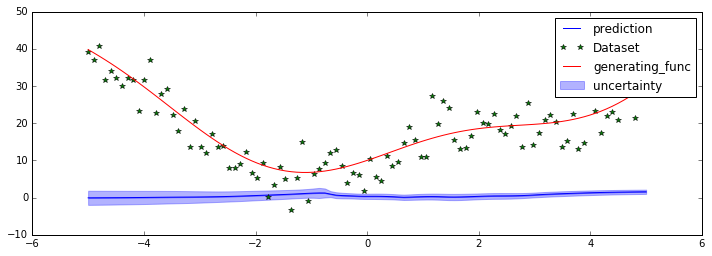

In [19]:
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

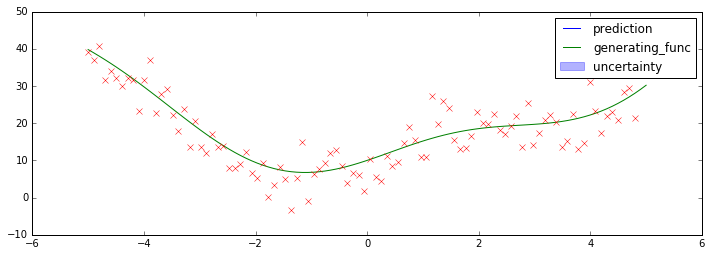

RSME is nan
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is nan
COVERAGE/MEAN_VAR is nan
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (nan, 1.0)


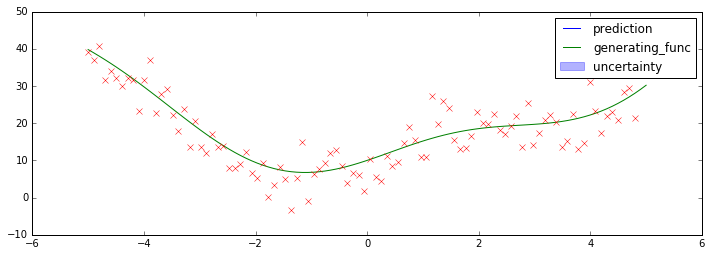

RSME is nan
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is nan
COVERAGE/MEAN_VAR is nan
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (nan, 1.0)


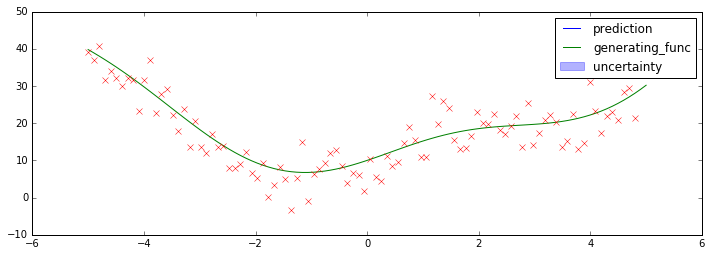

RSME is nan
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is nan
COVERAGE/MEAN_VAR is nan
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (nan, 1.0)


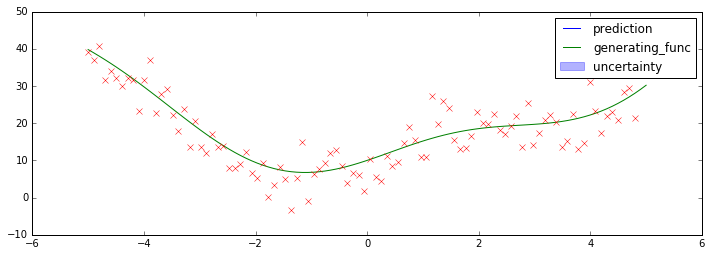

RSME is nan
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is nan
COVERAGE/MEAN_VAR is nan
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (nan, 1.0)


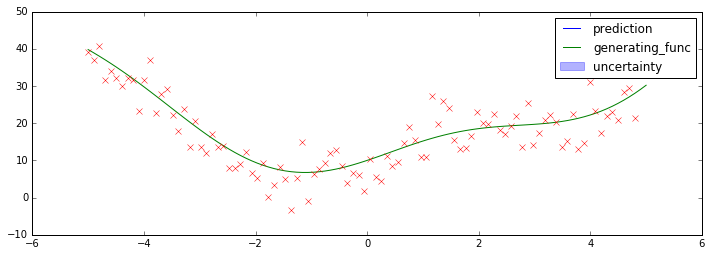

RSME is nan
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is nan
COVERAGE/MEAN_VAR is nan
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (nan, 1.0)


In [20]:
#gauss_error_list = []
for i in range(num_eps):
    gauss.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = gauss.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [21]:
gauss.train(X,y)

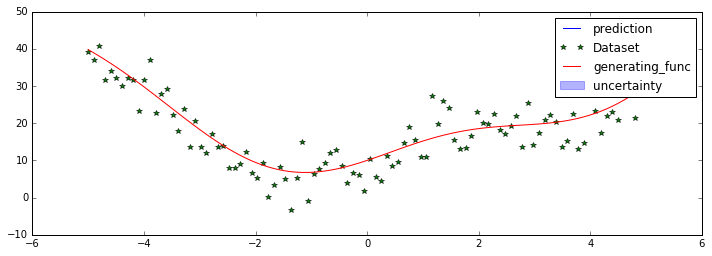

In [22]:
gauss_dict = gauss.predict(X)
mean,std = get_mean_var(gauss_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Learning Rate stuff


In [23]:
gauss_lr = GaussianLRNetworkEnsemble(estimator_stats = ensemble)

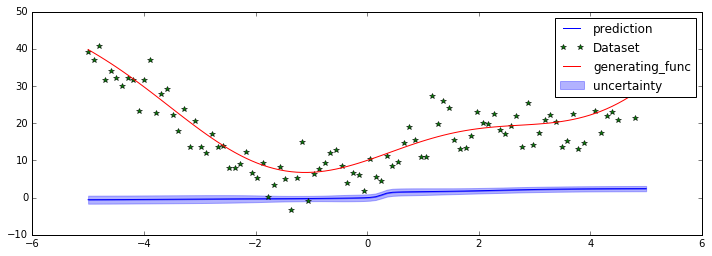

In [24]:
gauss_lr_dict = gauss_lr.predict(X)
mean,std = get_mean_var(gauss_lr_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

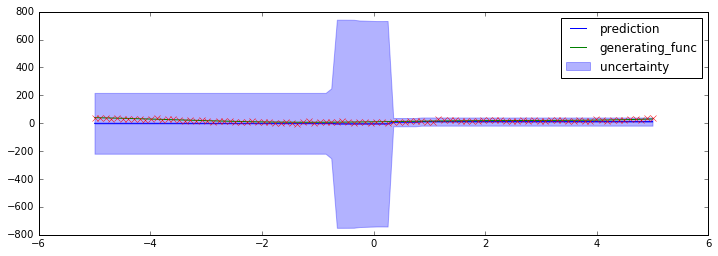

RSME is 16.58179473876953
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 181.97390747070312
COVERAGE/MEAN_VAR is 0.005495293330231945
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.097211257, 0.33596324099650665)


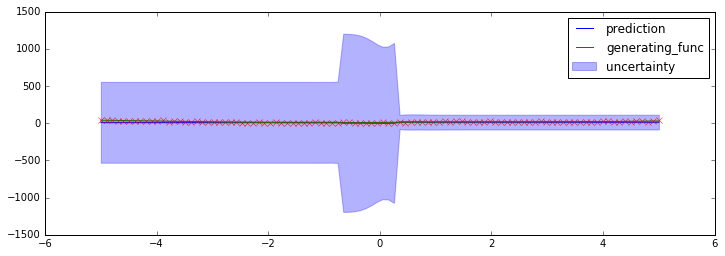

RSME is 10.381974220275879
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 392.4814453125
COVERAGE/MEAN_VAR is 0.0025478911473223505
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.076262221, 0.45076915710735943)


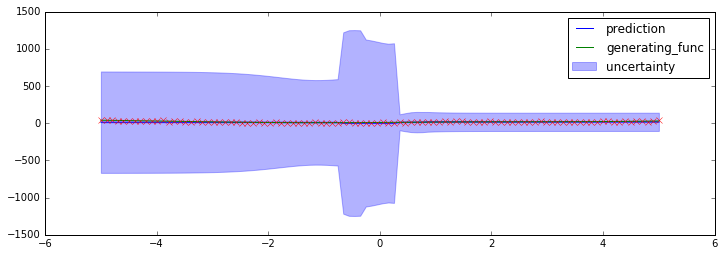

RSME is 9.315112113952637
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 450.6628112792969
COVERAGE/MEAN_VAR is 0.0022189538940683815
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.22806315, 0.022482153824360685)


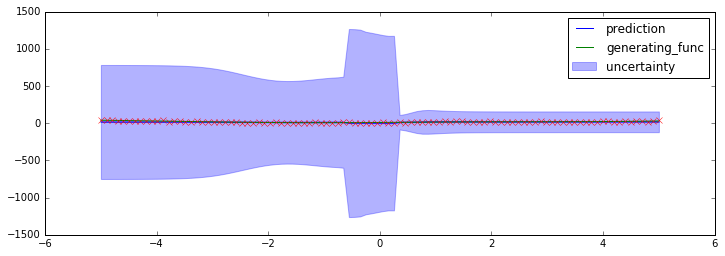

RSME is 8.439711570739746
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 472.9921875
COVERAGE/MEAN_VAR is 0.002114199824917827
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.23757213, 0.017311032298257575)


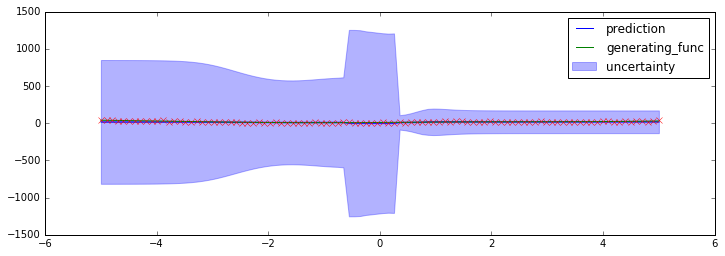

RSME is 8.14910888671875
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 495.4100646972656
COVERAGE/MEAN_VAR is 0.002018529842769905
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.27571541, 0.005494380469987274)


In [25]:
#gauss_error_list = []
for i in range(num_eps):
    gauss_lr.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = gauss_lr.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [26]:
gauss_lr.train(X,y)

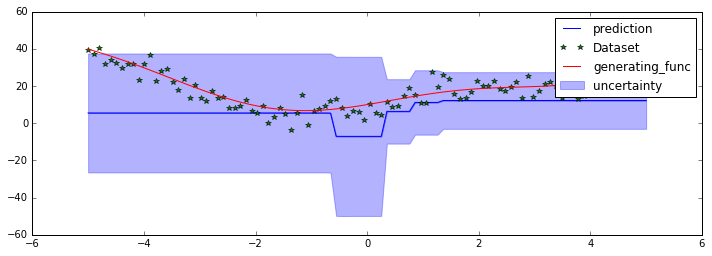

In [27]:
gauss_lr_dict = gauss_lr.predict(X)
mean,std = get_mean_var(gauss_lr_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)